# **Time Series: Bitcoin Price Prediction Case Study**


**Context**

Bitcoin is a decentralized digital currency that uses encryption schemes, decentralized
consensus, and other mechanisms to verify transactions and ensure security. It is a revolutionary
cryptocurrency that has signaled a paradigm shift in the meaning of wealth and payments, and it
has attracted extensive attention from investors, researchers, regulators as well as print & online
media all over the world.

**Objective**
An unusual feature of Bitcoin price is the large fluctuation in contrast to traditional financial
assets (such as gold, stock indexes, and commodities). This dataset consists of monthly average
closing prices of Bitcoin from Dec 2011 to March 2021. We have to build a time series model
using the ARIMA model to predict the monthly average closing price of Bitcoin.

**Data Dictionary**
1. Timestamp: Date when the price was collected
2. Close: The closing price of Bitcoin

# **Data Loading and Pre-Processing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# read the data
df = pd.read_csv('/content/drive/MyDrive/Predictive Analysis/Practical8/Copy of bitcoin.csv')
# returns the first 5 rows
df.head()

,Timestamp,Close
0,31-12-2011,4.482500
1,31-01-2012,6.208932
2,29-02-2012,5.252514
3,31-03-2012,4.961054
4,30-04-2012,4.976416


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Predictive Analysis/Practical8/Copy of bitcoin.csv', usecols=['Timestamp', 'Close'])  # Load specific columns

print(df.columns)


Index(['Timestamp', 'Close'], dtype='object')


In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.sort_index()  # Ensure chronological order
df.head()

,Close
Timestamp,
2011-12-31,4.482500
2012-01-31,6.208932
2012-02-29,5.252514
2012-03-31,4.961054
2012-04-30,4.976416


In [6]:
df.tail()

,Close
Timestamp,
2020-11-30,16530.43287
2020-12-31,21811.29527
2021-01-31,34553.59945
2021-02-28,46077.06320
2021-03-31,54641.41297


In [7]:
print(df.isnull().sum())


Close    0
dtype: int64


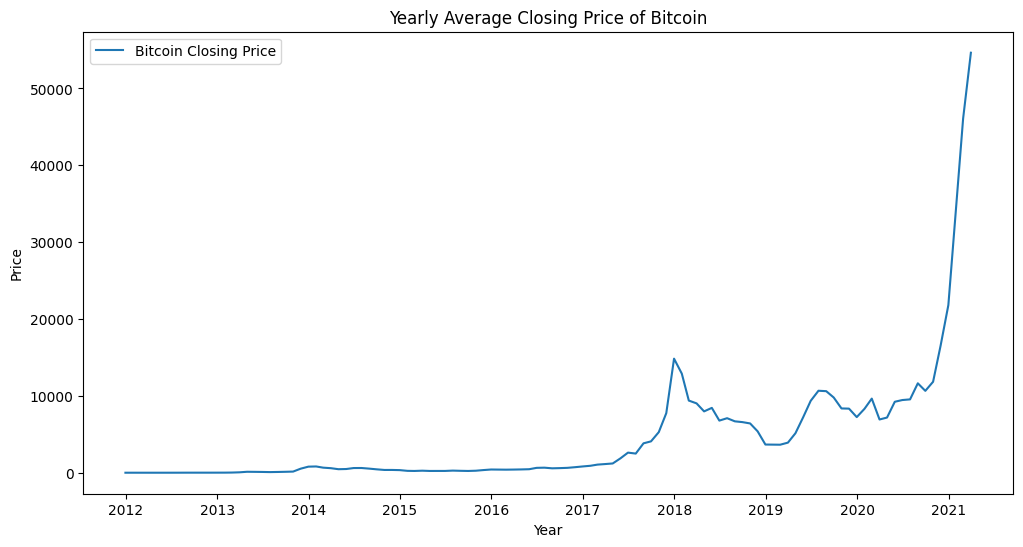

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Bitcoin Closing Price')
plt.title("Yearly Average Closing Price of Bitcoin")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()


# **Exploratory Data Analysis (EDA)**

In [9]:
print(df.describe())


              Close
count    112.000000
mean    4573.171872
std     8197.126362
min        4.482500
25%      245.157078
50%      662.186798
75%     7193.584259
max    54641.412970


**Stationarity Check**

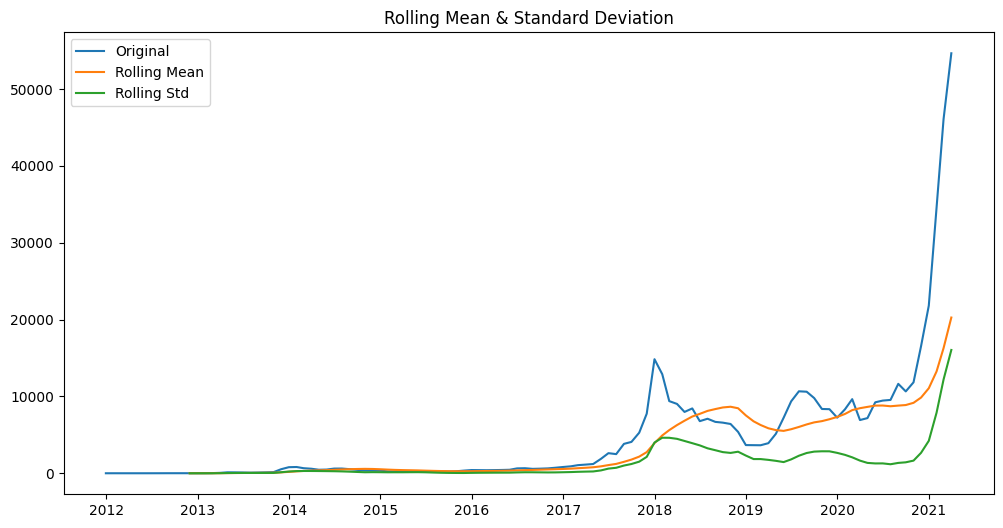

In [10]:
rolling_mean = df['Close'].rolling(window=12).mean()
rolling_std = df['Close'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


# **Augmented Dickey-Fuller test**

In [11]:
adf_test = adfuller(df['Close'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


ADF Statistic: 2.176441149410214
p-value: 0.9988625546358211


**Observations:**

1. A high p-value suggests that we fail to reject the null hypothesis, so the series is non-stationary.

2. A positive ADF statistic typically strengthens the evidence that the series is non-stationary.


# **Stationarize the Data**

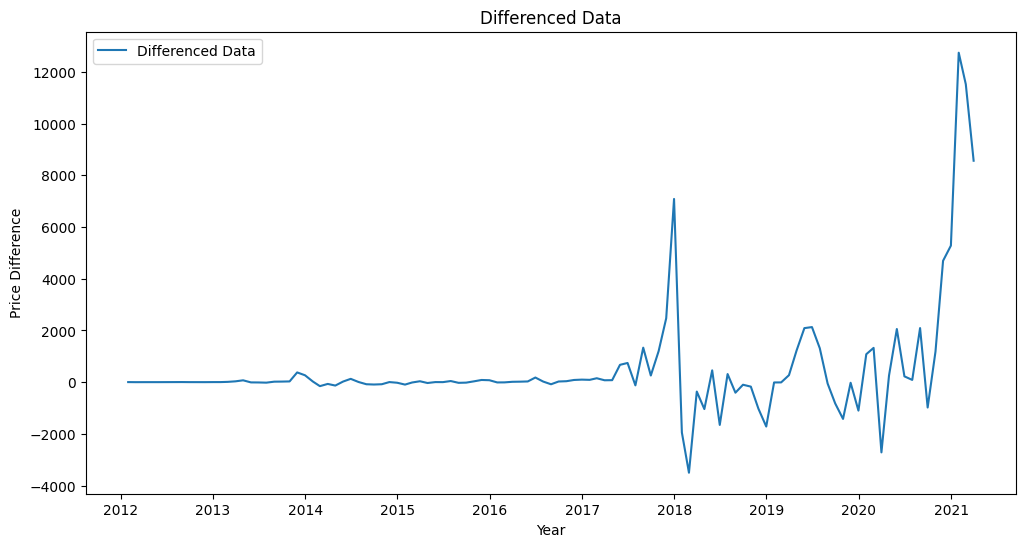

ADF Statistic (Differenced): -3.290830660868505
p-value (Differenced): 0.015293352626370008


In [12]:
df_diff = df['Close'].diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Differenced Data')
plt.title("Differenced Data")
plt.xlabel("Year")
plt.ylabel("Price Difference")
plt.legend()
plt.show()

# Recheck stationarity after differencing:
adf_test_diff = adfuller(df_diff)
print(f"ADF Statistic (Differenced): {adf_test_diff[0]}")
print(f"p-value (Differenced): {adf_test_diff[1]}")


**Observations**:

Since the p-value is below the typical threshold of 0.05, we can reject the null hypothesis. This suggests that the differenced series is now stationary.

# **ARIMA Parameters**

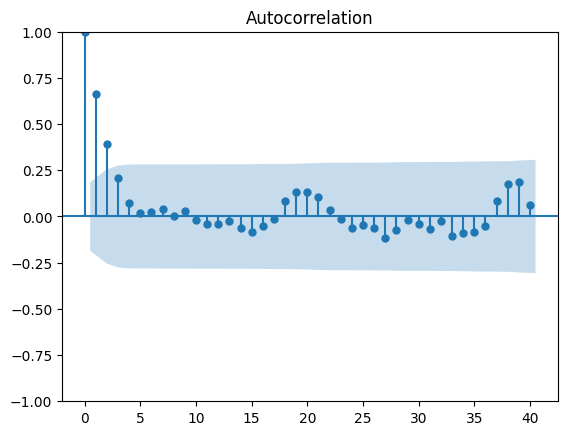

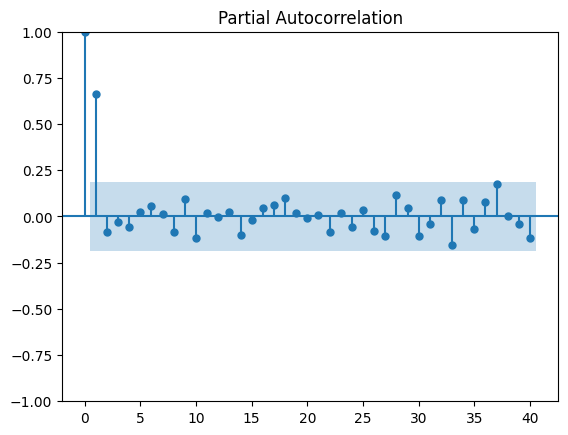

In [13]:
plot_acf(df_diff, lags=40)
plt.show()

plot_pacf(df_diff, lags=40)
plt.show()


**Observations:**

**ACF Plot:**

1. Significant spike at lag 1, followed by a gradual decay.

2. This indicates the presence of an MA (Moving Average) component in the data.

**PACF Plot:**

1. Significant spike at lag 1, followed by an immediate drop-off.

2. This suggests the presence of an AR (Autoregressive) component.

# **ARIMA Model**

In [14]:
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]


In [15]:
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   89
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -729.017
Date:                Tue, 06 May 2025   AIC                           1468.034
Time:                        04:42:11   BIC                           1480.420
Sample:                    12-31-2011   HQIC                          1473.024
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6625      0.296     -2.241      0.025      -1.242      -0.083
ar.L2         -0.7042      0.190     -3.702      0.000      -1.077      -0.331
ma.L1          0.8616      0.288      2.988      0.0

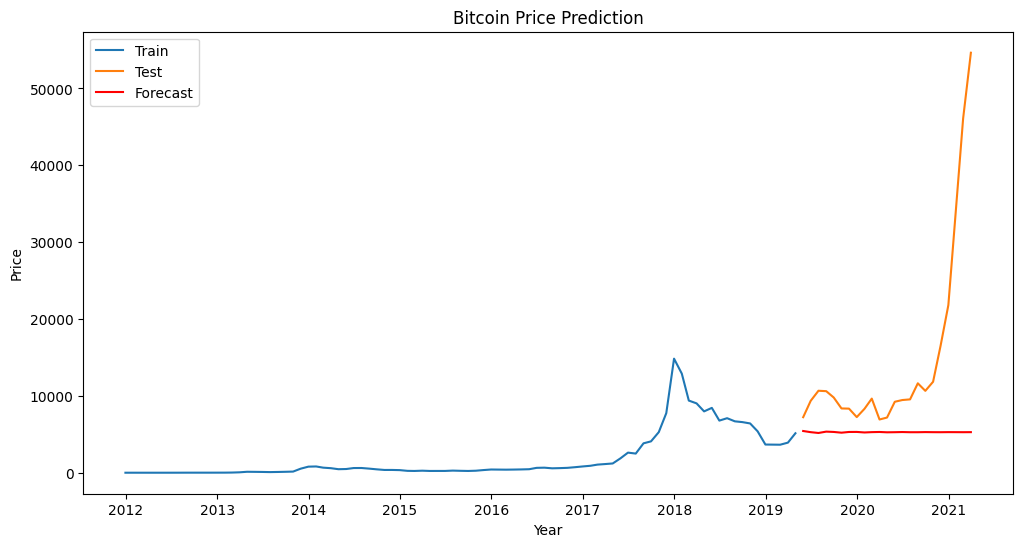

In [16]:
# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Convert forecast to a pandas Series and match the index
forecast_series = pd.Series(forecast, index=test.index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title("Bitcoin Price Prediction")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()


**Observation:**

The forecast (red line) appears to follow a similar trend as the test data (orange line) but with some deviations, indicating the model captures general trends but may miss finer details or sudden price changes.

# **Model Evaluation**

In [17]:
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 15710.233033736573


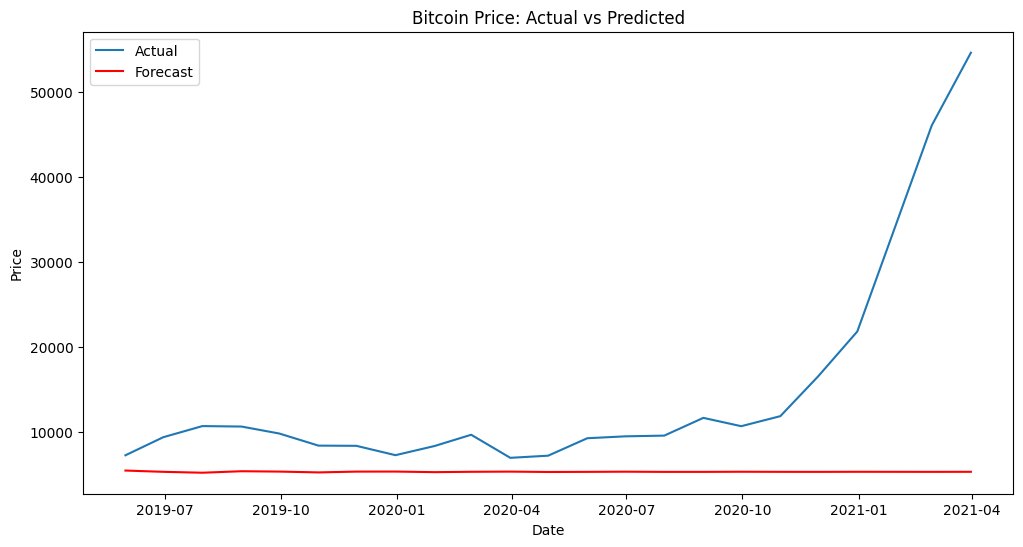

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title("Bitcoin Price: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
